In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
 
from scipy import stats as stats

from scipy.stats import norm as norm
from scipy.stats import triang as triang
from scipy.stats import beta as beta
from scipy.stats import rv_continuous
import scipy.optimize as opt


import warnings
warnings.filterwarnings("ignore")


ksN = 100           # Kolmogorov-Smirnov KS test for goodness of fit: samples
ALPHA = 0.05        # significance level for hypothesis test

In [26]:
# choose parameters for instantiating an example of a triangular or PERT distribution

min, mode, max, lmb = 10.0, 20.0, 40.0, 4.0

xx = 21.4               # evaluate pdf and cdf at xx
q = 0.5                 # a chosen quantile probability, e.g. 0.5 for median


# 1. Triangular distribution

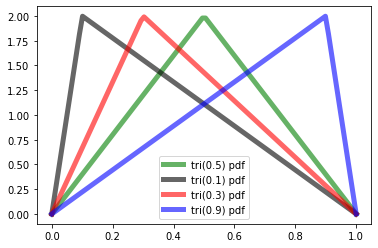

In [27]:
# for comparison: triangular models with different min, mode, and max values
rv1 = triang(0.5, 0.0, 1.0)
rv2 = triang(0.1, 0.0, 1.0)
rv3 = triang(0.3, 0.0, 1.0)
rv4 = triang(0.9, 0.0, 1.0)

x = np.linspace(0.0, 1.0, 100)

fig, ax = plt.subplots(1, 1)

ax.plot(x, rv1.pdf(x), 'g-', lw=5, alpha=0.6, label='tri(0.5) pdf')
ax.plot(x, rv2.pdf(x), 'k-', lw=5, alpha=0.6, label='tri(0.1) pdf')
ax.plot(x, rv3.pdf(x), 'r-', lw=5, alpha=0.6, label='tri(0.3) pdf')
ax.plot(x, rv4.pdf(x), 'b-', lw=5, alpha=0.6, label='tri(0.9) pdf')
ax.legend()
pass

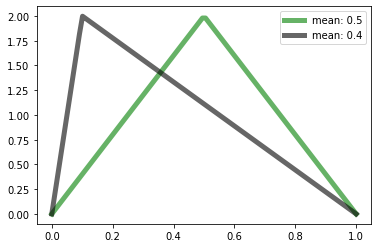

In [28]:
# for comparison: triangular models with different min, mode, and max values
rv1 = triang(0.5, 0.0, 1.0)
rv2 = triang(0.1, 0.0, 1.0)

rv1m = f'mean: {rv1.mean():.1f}'
rv2m = f'mean: {rv2.mean():.1f}'

x = np.linspace(0.0, 1.0, 100)

fig, ax = plt.subplots(1, 1)

ax.plot(x, rv1.pdf(x), 'g-', lw=5, alpha=0.6, label=rv1m)
ax.plot(x, rv2.pdf(x), 'k-', lw=5, alpha=0.6, label=rv2m)

ax.legend()
pass

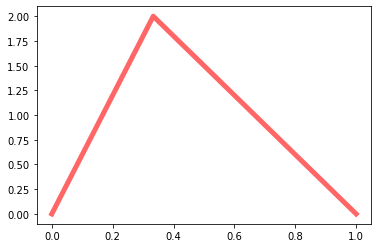

In [29]:
# instantiate a triangular distribution

# rescale the mode, min, and max parameters to fit the unit interval [0;1]
c = (mode - min) / (max - min)

# instantiate the triangular distribution
rvT = triang(c)

# plot the pdf
x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, rvT.pdf(x), 'r-', lw=5, alpha=0.6, label='Triangular pdf')
pass

In [30]:
# mean of the triangular
mean = rvT.mean() *(max - min) + min
print(mean)

23.333333333333332


In [31]:
# moments of the triangular
kurt = rvT.stats("mvsk")
print(kurt)

(array(0.44444444), array(0.04320988), array(0.30544142), array(-0.6))


# 2. Modified PERT

In [32]:
# define a new class pertm_gen: a generator for the PERT distribution

class pertm_gen(rv_continuous):
    '''modified beta_PERT distribution'''

 
    def _shape(self, min, mode, max, lmb):
        s_alpha = 1+ lmb*(mode - min)/(max-min)
        s_beta = 1 + lmb*(max - mode)/(max-min)
        return [s_alpha, s_beta]


    def _cdf(self, x, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        z = (x - min) / (max - min)
        cdf = beta.cdf(z, s_alpha, s_beta)
        return cdf

    def _ppf(self, p, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        ppf = beta.ppf(p, s_alpha, s_beta)
        ppf = ppf * (max - min) + min
        return ppf


    def _mean(self, min, mode, max, lmb):
        mean = (min + lmb * mode + max) / (2 + lmb)
        return mean

    def _var(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = (mean - min) * (max - mean) / (lmb + 3)
        return var

    def _skew(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        skew1 = (min + max - 2*mean) / 4
        skew2 = (mean - min) * (max  - mean)
        skew2 = np.sqrt(7 / skew2)
        skew = skew1 * skew2
        return skew

    def _kurt(self, min, mode, max, lmb):
        a1,a2 = self._shape(min, mode, max, lmb)
        kurt1 = a1 + a2 +1
        kurt2 = 2 * (a1 + a2)**2
        kurt3 = a1 * a2 * (a1 + a2 - 6)
        kurt4 = a1 * a2 * (a1 + a2 + 2) * (a1 + a2 + 3)
        kurt5 = 3 * kurt1 * (kurt2 + kurt3)
        kurt = kurt5 / kurt4 -  3                 # scipy defines kurtosis of std normal distribution as 0 instead of 3
        return kurt

    def _stats(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = self._var(min, mode, max, lmb)
        skew = self._skew(min, mode, max, lmb)
        kurt = self._kurt(min, mode, max, lmb)
        return mean, var, skew, kurt


(array(3.3), array(0.98272727), array(0.48282241), array(-0.23610617))
(array(3.), array(1.), array(0.), array(0.))


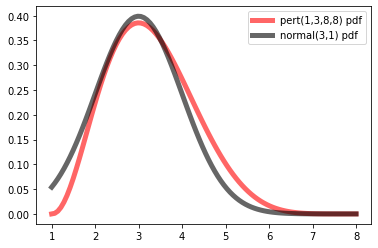

In [33]:
# instantiate a pert distribution object and a normal distribution
# compare their curves

pertm = pertm_gen(name="pertm")
rvP = pertm(1, 3, 8, 8.0)
rvN = norm(3, 1)

statsP = rvP.stats("mvsk")
statsN = rvN.stats("mvsk")
print(statsP)
print(statsN)

x = np.linspace(1.0, 8.0, 100)
fig, ax = plt.subplots(1, 1)

ax.plot(x, rvP.pdf(x), 'r-', lw=5, alpha=0.6, label='pert(1,3,8,8) pdf')
ax.plot(x, rvN.pdf(x), 'k-', lw=5, alpha=0.6, label='normal(3,1) pdf')
ax.legend()
pass

PERT kurtosis, dependending on lambda:
[-0.545454545454545, -0.9599999999999995, -0.41454545454545455, -0.23529411764705888]


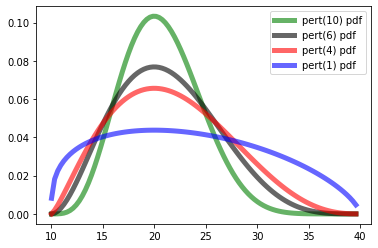

In [34]:
# for comparison: PERT models with different lambda weights
# assign pert distributions with different lambda parameters to variables for plotting their curves

rv4 = pertm(min, mode, max, 4.0)
rv1 = pertm(min, mode, max, 1.0)
rv6 = pertm(min, mode, max, 6.0)
rv12 = pertm(min, mode, max, 12.0)

# kurtosis:
kurt4 = np.asscalar(rv4.stats('mvsk')[3])
kurt1 = np.asscalar(rv1.stats('mvsk')[3])
kurt6 = np.asscalar(rv6.stats('mvsk')[3])
kurt12 = np.asscalar(rv12.stats('mvsk')[3])
print("PERT kurtosis, dependending on lambda:")
print([kurt4, kurt1, kurt6, kurt12])

x = np.linspace(rv4.ppf(0.000001), rv4.ppf(0.999999), 100)

fig, ax = plt.subplots(1, 1)

ax.plot(x, rv12.pdf(x), 'g-', lw=5, alpha=0.6, label='pert(10) pdf')
ax.plot(x, rv6.pdf(x), 'k-', lw=5, alpha=0.6, label='pert(6) pdf')
ax.plot(x, rv4.pdf(x), 'r-', lw=5, alpha=0.6, label='pert(4) pdf')
ax.plot(x, rv1.pdf(x), 'b-', lw=5, alpha=0.6, label='pert(1) pdf')
ax.legend()
pass

In [35]:
# define a shorter, less complete class for a generator for the PERT distribution,
# which contains only the formula for the PERT cdf 
# SciPy will have to solve numerically for all other properties 

class pertm_gen_less(rv_continuous):
    '''modified beta_PERT distribution'''


    def _shape(self, min, mode, max, lmb):
        s_alpha = 1+ lmb*(mode - min)/(max-min)
        s_beta = 1 + lmb*(max - mode)/(max-min)
        return [s_alpha, s_beta]


    def _cdf(self, x, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        z = (x - min) / (max - min)
        cdf = beta.cdf(z, s_alpha, s_beta)
        return cdf


In [36]:
# define a method that returns a couple of metrics for an instantiated pert object

def pertm_results(x, min, mode, max, lmb):
    tStart = time.perf_counter()

    cdfx = pertm._cdf(x, min, mode, max, lmb)
    print(cdfx)

    pdfx = pertm._pdf(x, min, mode, max, lmb)
    print(pdfx)

    ppfp  = pertm._ppf(cdfx, min, mode, max, lmb)
    print(ppfp)

    stats = pertm._stats(min, mode, max, lmb)
    print(stats)

    t = time.perf_counter() - tStart
    res = f'{t:.4f} sec'
    print(res)
    
    return t


In [37]:
# instantiate a PERT distribution object from the more comprehensive pert class
# and receive some of its metrics from the pert_results function

pertm = pertm_gen(name="pertm")

rv = pertm(min, mode, max, lmb)

res = pertm_results(xx, min, mode, max, lmb)


0.5081051631417833
0.06441490140382533
21.4
(21.666666666666668, 30.555555555555554, 0.3015113445777635, -0.545454545454545)
0.0024 sec


In [38]:
# get the same metrics from the less complete pert class

pertm_less = pertm_gen_less(name = "pertm")
rv = pertm_less(min, mode, max, lmb)

res_less = pertm_results(xx, min, mode, max, lmb)

print(f'{res_less/res:.1f} times as much time is required for the less complete class')

0.5081051631417833
0.06441490140382533
21.4
(21.666666666666668, 30.555555555555554, 0.3015113445777635, -0.545454545454545)
0.0016 sec
0.7 times as much time is required for the less complete class


In [39]:
# metrics of the pert distribution = transformed beta with loc and scale parameters

moments_values = rv.stats("mvsk")

moments_names = ["mean", "var", "skew", "kurt"]
moments = dict(zip(moments_names, moments_values))
_ = [print(k,":",f'{v:.3f}') for k,v in moments.items()]


mean : 21.667
var : 30.556
skew : 0.302
kurt : -0.545


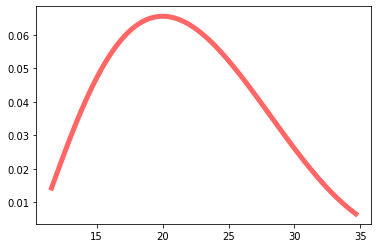

In [40]:
# plot the pdf
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='PERT pdf')
pass

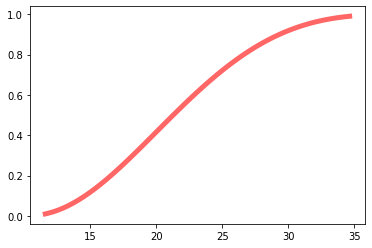

In [41]:
# plot the cdf
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.cdf(x), 'r-', lw=5, alpha=0.6, label='PERT cdf')
pass

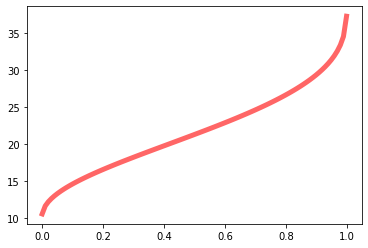

In [42]:
# plot the ppf
x = np.linspace(0.001, 0.999, 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.ppf(x), 'r-', lw=5, alpha=0.6, label='PERT quantile function')
pass

In [43]:
# interval around the median for chosen significance levels
probs = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]  # probability that an rv will be drawn from the range
interv = rv.interval(probs)
interv = list(zip(*interv))
dict_interv = dict(zip(probs, interv))
_ = [print(p,":",x) for p,x in dict_interv.items()]


0.001 : (21.266638363276503, 21.2821135025359)
0.01 : (21.19707032292252, 21.35182466003185)
0.1 : (20.50638334850256, 22.056885657895375)
0.2 : (19.74415190063587, 22.863447306097516)
0.3 : (18.97882277766881, 23.705395062651537)
0.4 : (18.200465492438, 24.597369197613144)
0.5 : (17.39667127490647, 25.55990066157477)
0.6 : (16.55002650600454, 26.624519071882066)
0.7 : (15.632600673189959, 27.845525355296076)
0.8 : (14.590830810294376, 29.333700928617418)
0.9 : (13.284971759949832, 31.39862159639642)
0.95 : (12.379178374470632, 33.01599182737671)
0.99 : (11.153925333784576, 35.62651618031904)
0.999 : (10.421691099137718, 37.71627205740342)


In [44]:
# cdf(x) and pdf(x) for selected points x

xeval = [100.0, rv.ppf(0.01), rv.ppf(0.1), 120.0, rv.median(), rv.mean(), rv.ppf(0.9), rv.ppf(.99), 300.0, 320.0]
cdfx = rv.cdf(xeval)
pdfx = rv.pdf(xeval)
xcp = zip(xeval, cdfx, pdfx)
_ = {print(f'{k:.2f}',":",f'{c:.4f}',"/",f'{p:.4f}') for k,c,p in xcp}

100.00 : 1.0000 / 0.0000
11.57 : 0.0100 / 0.0142
14.59 : 0.1000 / 0.0440
120.00 : 1.0000 / 0.0000
21.27 : 0.5000 / 0.0646
21.67 : 0.5252 / 0.0639
29.33 : 0.9000 / 0.0296
34.66 : 0.9900 / 0.0065
300.00 : 1.0000 / 0.0000
320.00 : 1.0000 / 0.0000


# 2. Expert Estimate: 10% Quantile, Mode, and 90% Quantile instead of Min, Mode, Max

In [45]:
# the experts provide estimates for 3 key points: the 10%, 50%, 90% quantiles
# we re-use the parameters of the previous example

q10 = rv.ppf(0.1)
mode = mode + 0
q90 = rv.ppf(0.9)

dict_q = {"q10":q10, "mode":mode, "q90":q90}
_ = [print(k,":",f'{v:.2f}') for k,v in dict_q.items()]


q10 : 14.59
mode : 20.00
q90 : 29.33


## 2.1 Translate q10, q90 to min,max before using the conventional PERT

In [46]:
# solve 2 nonlinear equations to obtain min,max from the 2 quantiles

lmb = 4.0

def f(init_vars):
    min, max = init_vars
    eq10 = pertm._ppf(0.1, min, mode, max, lmb) - q10
    eq90 = pertm._ppf(0.9, min, mode, max, lmb) - q90
    return (eq10, eq90)

# solve nonlinear equations: deduce  min,max from quantiles q10,q90
init_vars = (q10 * 0.01, q90 * 100.0)
params = opt.fsolve(f, init_vars)


In [47]:
# review results:

params = list(params)
# insert lambda and mode besides min and max:
params.append(lmb)
params.insert(1, mode)
param_names = ["min", "mode", "max", "lambda"]
dict_params = dict(zip(param_names, params))
print("\nPERT parameters:")
_ = [print(k,":",f'{v:.1f}') for k,v in dict_params.items()]
min, mode, max, lmb = params


# compute chosen quantiles:
probs = [1e-12, 0.1, 0.5, 0.9, 1 - 1e-12]
quantiles = [pertm.ppf(q, min,mode,max,lmb) for q in probs]
quantiles = dict(zip(probs, quantiles))
print("\nselected quantiles:")
_ = [print(f'{q:.3f}',":",f'{x:.2f}') for q,x in quantiles.items()]

print("\nsupport:")
print(pertm.support(min,mode,max,lmb))


PERT parameters:
min : 10.0
mode : 20.0
max : 40.0
lambda : 4.0

selected quantiles:
0.000 : 10.00
0.100 : 14.59
0.500 : 21.27
0.900 : 29.33
1.000 : 39.99

support:
(-inf, inf)


## 2.2 Create a new PERT-Q that can be parametrized with 10% and 90% quantiles --
## no need to translate q10,q90 to min,max before entering them in the conventional PERT

In [48]:
# define a new class: a generator for a PERT distribution
# that is parametrized with quantiles q10,q90 instead of min,max


class pertQ_gen(pertm_gen):
    '''beta_PERT distribution based on quantiles q10, q90 instead of min, max'''

    L = 4.0


    # system of quantile equations for min,max for given mode,lmb,q10,q90
    def f(self, init_vars):
        min, max = init_vars
        eq10 = pertm._ppf(0.1, min, mode, max, L) - q10
        eq90 = pertm._ppf(0.9, min, mode, max, L) - q90
        return (eq10, eq90)


    # solve system of quantile equations for given q10,mode,q90,lmb
    def _minmax(self, q10, mode, q90, L):

        # solve nonlinear equations: deduce min,max from quantiles q10,q90
        init_vars = (q10 * 0.01, q90 * 100.0)
        params = opt.fsolve(f, init_vars)
        params = list(params)
        # insert lambda and mode besides min and max and return all 4 parameters:
        params.append(L)
        params.insert(1, mode)
        return params


    def _shape(self, min, mode, max, L):
        s_alpha = 1+ L*(mode - min)/(max-min)
        s_beta = 1 + L*(max - mode)/(max-min)
        return [s_alpha, s_beta]


    def _cdf(self, x, q10, mode, q90, L):
        min, mode, max, LL = self._minmax(q10, mode, q90, L)
        s_alpha, s_beta = self._shape(min, mode, max, L)
        z = (x - min) / (max - min)
        cdf = beta.cdf(z, s_alpha, s_beta)
        return cdf


In [49]:
# instantiate a pertQ distribution object
pertQ = pertQ_gen(name = "pertQ")

# freeze the pertQ instance with its parameters
rvQ = pertQ(q10, mode, q90, 4.0)


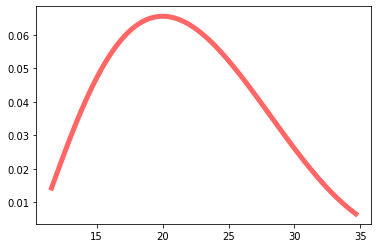

In [50]:
# plot the pdf
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, rvQ.pdf(x), 'r-', lw=5, alpha=0.6, label='PERT-Q pdf')
pass

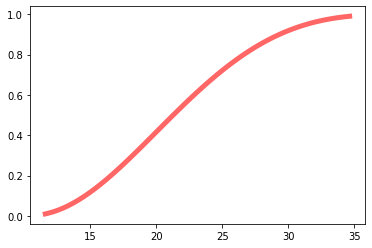

In [51]:
# plot the cdf
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, rvQ.cdf(x), 'r-', lw=5, alpha=0.6, label='PERT-Q cdf')
pass

In [52]:
# cdf(x) and pdf(x) for selected points x of pertQ
# compare with values of conventional PERT
# left: pertQ, right: pert

cdfxq = rv.cdf(xeval)
pdfxq = rv.pdf(xeval)
xcpq = zip(xeval, cdfx, pdfx, cdfxq, pdfxq)
_ = {print(f'{x:.2f}',":",f'{c:.4f}',"=",f'{cq:.4f}','|', f'{p:.4f}',"=",f'{pq:.4f}') for x,cq,pq,c,p in xcpq}

100.00 : 1.0000 = 1.0000 | 0.0000 = 0.0000
11.57 : 0.0100 = 0.0100 | 0.0142 = 0.0142
14.59 : 0.1000 = 0.1000 | 0.0440 = 0.0440
120.00 : 1.0000 = 1.0000 | 0.0000 = 0.0000
21.27 : 0.5000 = 0.5000 | 0.0646 = 0.0646
21.67 : 0.5252 = 0.5252 | 0.0639 = 0.0639
29.33 : 0.9000 = 0.9000 | 0.0296 = 0.0296
34.66 : 0.9900 = 0.9900 | 0.0065 = 0.0065
300.00 : 1.0000 = 1.0000 | 0.0000 = 0.0000
320.00 : 1.0000 = 1.0000 | 0.0000 = 0.0000


In [53]:
# metrics of the pertQ distribution = metrics of conventional pert

moments_valuesQ = rv.stats("mvsk")

moments_names = ["mean", "var", "skew", "kurt"]

df = pd.DataFrame([moments_names, moments_valuesQ, moments_values]).T
df.rename(columns={0:"moment",1:"pertQ",2:"pert"}, inplace=True)
df


,moment,pertQ,pert
0,mean,21.666666666668245,21.666666666668245
1,var,30.55555555534744,30.55555555534744
2,skew,0.3015113446376056,0.3015113446376056
3,kurt,-0.5454545457512037,-0.5454545457512037
